<a href="https://colab.research.google.com/github/dlsyscourse/public_notebooks/blob/main/24_machine_learning_compilation_deployment_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 24: Machine Learning Compiler and Deployment

In this lecture, we will walk you through some example usage of the machine learning compiler Apache TVM. To learn more, checkout https://tvm.apache.org/

The content of this lecture is adapted from TVM's tutorials.



## Install package

To get started, we need to obtain a version of TVM. For quick demo purpose we will use the following command to install a latest version of the TVM unity compiler and related language model dependenchy solution

In [2]:
!pip install --pre  mlc-ai-nightly-cu118 mlc-chat-nightly-cu118 -f https://mlc.ai/wheels

Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.5/544.5 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not 

## Loop-level representation and transformations

Let us start with a vector add example. the follow code snippet allows us to create a vector add code, and store it in a container called IRModule.

In [4]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T
import numpy as np

In [5]:
def lnumpy_add(a, b, c):
    for i in range(128):
        c[i] = a[i] + b[i]

In [6]:
from tvm import te

A = te.placeholder(shape=(128,), dtype="float32", name="A")
B = te.placeholder(shape=(128,), dtype="float32", name="B")
C = te.compute((128,), lambda i: A[i] + B[i], name="C")
func = te.create_prim_func([A, B, C])
func = func.with_attr("global_symbol", "main")
ir_module = IRModule({"main": func})

An IRModule contains a collection of low-level functions, we can use the script function to inspect the functions inside an IRModule.  

In [7]:
ir_module.show()

### Build and run

We can turn the programs in an IRModule to runnable functions by calling a build function.

In [16]:
rt_mod = tvm.build(ir_module, target="llvm")  # The module for CPU backends.
print(type(rt_mod))

<class 'tvm.driver.build_module.OperatorModule'>


After build, mod contains a collection of runnable functions. We can retrieve each function by its name.

In [17]:
func = rt_mod["main"]

In [ ]:
func

In [25]:
a = tvm.nd.array(np.arange(128, dtype="float32"))

In [24]:
b = tvm.nd.array(np.ones(128, dtype="float32"))

In [26]:
c = tvm.nd.empty((128,), dtype="float32")

In [27]:
 c

<tvm.nd.NDArray shape=(128,), cpu(0)>
array([ 1.5414283e-44,  0.0000000e+00, -1.8209923e+38,  5.9951127e-36,
        9.3680810e-38,            nan, -1.7944576e+38,            nan,
       -1.7950287e+38,  1.5046100e-36, -2.3580977e-13,  5.0714873e+03,
       -2.1031324e-29,  4.3239867e-41, -1.0050381e-27,  4.3239867e-41,
       -5.0817178e-28,  7.4720040e-31, -5.4709796e-29,  4.3239867e-41,
       -3.8291387e-29,  4.3239867e-41, -3.0956019e+08,  3.5900357e+37,
       -2.1032094e-29,  4.3239867e-41, -2.1031901e-29,  4.3239867e-41,
        1.0217351e+24,  2.9740162e-25, -2.9161776e-28,  4.3239867e-41,
       -1.0050535e-27,  4.3239867e-41,  5.3499954e+35,  2.2136460e-08,
       -7.9329131e-28,  4.3239867e-41,  2.1864253e-07,  3.2584393e-41,
        3.7308126e+18, -1.3384625e-12, -2.1032190e-29,  4.3239867e-41,
       -1.0052569e-27,  4.3239867e-41,  2.3641396e+20,  1.1002859e+12,
       -2.1032286e-29,  4.3239867e-41, -1.0522280e-27,  4.3239867e-41,
       -1.2803440e-37,  7.2564893e-31, 

To invoke the function, we can create three NDArrays in the tvm runtime, and then invoke the generated function.

In [28]:
func(a, b, c)


In [29]:
print(a)
print(b)
print(c)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

### Transform the code

The IRModule is the central data structure for program optimization, which can be transformed by a helper class called Schedule. A schedule contains multiple primitive methods to interactively transform the program. Each primitive transforms the program in certain ways to bring additional performance optimizations.

Let us try to transform the module, we can do it by creating a Schedule instance.


In [30]:
sch = tvm.tir.Schedule(ir_module)

In [31]:
sch.mod.show()

In [32]:
blockC = sch.get_block("C")
i, = sch.get_loops(blockC)

In [33]:
i0, i1 = sch.split(i, factors=[None, 8])

In [34]:
sch.mod.show()

In [35]:
sch.reorder(i1, i0)

In [36]:
sch.mod.show()

In [37]:
sch.reorder(i0, i1)

In [38]:
sch.mod.show()

In [39]:
sch.parallel(i0)
sch.vectorize(i1)

In [40]:
sch.mod.show()

In [41]:
sch = tvm.tir.Schedule(ir_module)
print(type(sch))

<class 'tvm.tir.schedule.schedule.Schedule'>


In [42]:
ir_module.show()

In [ ]:
sch = tvm.tir.Schedule(ir_module)
block_C = sch.get_block("C")
i, = sch.get_loops(block_C)
i0, i1 = sch.split(i, [None, 8])
sch.reorder(i1, i0)
sch.parallel(i1)
sch.mod.show()

Let us first try to split the loops

In [43]:
# Get block by its name
block_c = sch.get_block("C")
# Get loops surronding the block
(i,) = sch.get_loops(block_c)
# Tile the loop nesting.
i_0, i_1, i_2 = sch.split(i, factors=[None, 4, 4])
sch.mod.show()

We can also reorder the loops, swapping the order of i_0 and i_1



In [44]:
sch.reorder(i_1, i_0, i_2)
sch.mod.show()

Finally, we can add hints to the program generator that we want to vectorize the inner most loop.

In [45]:
sch.vectorize(i_2)
sch.mod.show()

## Transforming a matrix multiplication program

In the above example, we showed how to transform an vector add. Now let us try to apply that to a slightly more complicated program(matrix multiplication).


In [46]:
M = 1024
K = 1024
N = 1024

# The default tensor type in tvm
dtype = "float32"

target = "llvm"
dev = tvm.device(target, 0)

# Algorithm
k = te.reduce_axis((0, K), "k")
A = te.placeholder((M, K), name="A")
B = te.placeholder((K, N), name="B")
C = te.compute((M, N), lambda m, n: te.sum(A[m, k] * B[k, n], axis=k), name="C")

# Default schedule
func = te.create_prim_func([A, B, C])
func = func.with_attr("global_symbol", "main")
ir_module = IRModule({"main": func})
ir_module.show()

In [47]:
func = tvm.build(ir_module, target="llvm")  # The module for CPU backends.
a_np = np.random.rand(M, K).astype(dtype)
b_np = np.random.rand(K, N).astype(dtype)
a = tvm.nd.array(a_np, dev)
b = tvm.nd.array(b_np, dev)
c = tvm.nd.array(np.zeros((M, N), dtype=dtype), dev)
func(a, b, c)

evaluator = func.time_evaluator("main", dev, number=3)
print("Baseline time cost %g sec" % evaluator(a, b, c).mean)

Baseline time cost 3.08041 sec


In [48]:
c.numpy() - a_np @b_np

array([[ 0.0000000e+00, -1.2207031e-04,  0.0000000e+00, ...,
         3.0517578e-05,  0.0000000e+00,  1.2207031e-04],
       [ 6.1035156e-05, -9.1552734e-05,  3.0517578e-05, ...,
        -9.1552734e-05, -1.5258789e-05,  0.0000000e+00],
       [-3.0517578e-05,  1.5258789e-04,  3.0517578e-05, ...,
         6.1035156e-05, -1.5258789e-04,  0.0000000e+00],
       ...,
       [-6.1035156e-05, -1.2207031e-04,  9.1552734e-05, ...,
        -1.2207031e-04, -1.3732910e-04,  1.2207031e-04],
       [-9.1552734e-05,  0.0000000e+00,  6.1035156e-05, ...,
         3.0517578e-05, -1.6784668e-04, -3.0517578e-05],
       [ 2.4414062e-04, -1.5258789e-04,  1.5258789e-04, ...,
        -1.3732910e-04, -1.2207031e-04, -7.6293945e-05]], dtype=float32)

In [52]:
ir_module.show()

We can transform the loop access pattern to make it more cache friendly. Let us use the following schedule.

In [53]:
def transform(sch, tile_m, tile_n):
    block_C = sch.get_block("C")
    m, n, k = sch.get_loops(block_C)
    mo, mi = sch.split(m, [None, tile_m])
    no, ni = sch.split(n, [None, tile_n])
    sch.reorder(mo, no, k, mi, ni)
    return sch
sch = tvm.tir.Schedule(ir_module)
sch = transform(sch, 8, 8)
sch.mod.show()

In [54]:
sch = tvm.tir.Schedule(ir_module)
sch = transform(sch, 32, 32)
sch.mod.show()
mod = tvm.build(sch.mod, target="llvm")
new_eval = mod.time_evaluator("main", number=3, dev=tvm.cpu())
print("Transformed time cost %g sec" % new_eval(a, b, c).mean)

Transformed time cost 0.300325 sec


Try to change the value of bn to see what performance you can get. In pratice, we will leverage an automated system to search over a set of possible transfromations to find an optimal one.



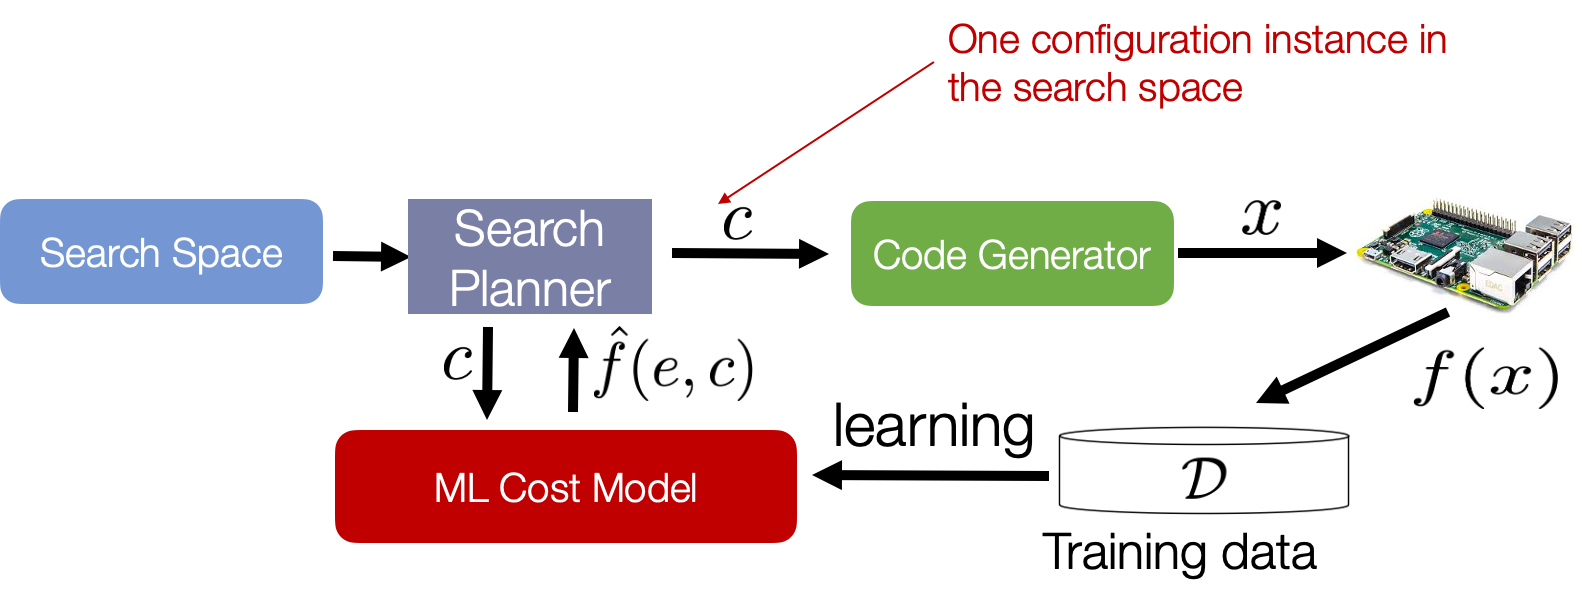

There are other optimizations that can be applied here, such as vectorization, parallelization and data layout optimization. Please checkout

## End to end model deployment

Finally, let us walk through an example flow for an end to end model deployment.



In [3]:
!git lfs install


Git LFS initialized.


In [4]:
!mkdir -p dist/prebuilt
!git clone https://github.com/mlc-ai/binary-mlc-llm-libs.git dist/prebuilt/lib

Cloning into 'dist/prebuilt/lib'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 389 (delta 94), reused 93 (delta 77), pack-reused 274
Receiving objects: 100% (389/389), 126.00 MiB | 14.01 MiB/s, done.
Resolving deltas: 100% (279/279), done.
Updating files: 100% (100/100), done.


In [5]:
!cd dist/prebuilt && git clone https://huggingface.co/mlc-ai/mlc-chat-Llama-2-7b-chat-hf-q4f16_1


Cloning into 'mlc-chat-Llama-2-7b-chat-hf-q4f16_1'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 129 (delta 0), reused 0 (delta 0), pack-reused 126
Receiving objects: 100% (129/129), 500.53 KiB | 19.25 MiB/s, done.
Filtering content: 100% (116/116), 3.53 GiB | 58.34 MiB/s, done.


In [6]:
from mlc_chat import ChatModule
from mlc_chat.callback import StreamToStdout

cm = ChatModule(model="Llama-2-7b-chat-hf-q4f16_1")

In [7]:
output = cm.generate(
    prompt="When was Python released?",
    progress_callback=StreamToStdout(callback_interval=2),
)

Hello! I'm glad you asked! Python was first released in 1991 by Guido van Rossum. It was initially called "Python" because van Rossum was a fan of the British comedy group Monty Python's Flying Circus. The language was created as a hobby project, and it quickly gained popularity among computer programmers due to its simplicity and ease of use. Since its initial release, Python has undergone many updates and improvements, and it has become one of the most popular programming languages in the world. Is there anything else you would like to know?


In [60]:
prompt = input("Prompt: ")
output = cm.generate(prompt=prompt, progress_callback=StreamToStdout(callback_interval=2))

Prompt: tell me about cmu
Carnegie Mellon University (CMU) is a private research university located in Pittsburgh, Pennsylvania, United States. It was founded in 1900 as the Carnegie Technical Schools by Andrew Carnegie, and later merged with the Mellon Institute of Industrial Research in 1967. CMU is highly regarded for its academic excellence, innovative research, and strong connections with industry leaders.
Here are some key points about Carnegie Mellon University:
1. Academics: CMU offers a wide range of undergraduate and graduate degree programs in fields such as engineering, computer science, robotics, artificial intelligence, business, public policy, and the arts. The university is known for its interdisciplinary approach to education, which allows students to explore multiple areas of interest.
2. Research: CMU is a leading research university, with a strong focus on interdisciplinary collaboration and innovation. The university has a long history of groundbreaking research in

In [62]:
print(cm.stats())


prefill: 506.3 tok/s, decode: 49.1 tok/s
